In [1]:
import sys
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np 
import os

import torch
from torch_geometric.utils import add_self_loops, degree

sys.path.append("..")

from spikeometric.models import BernoulliGLM
from spikeometric.datasets import NormalGenerator, ConnectivityDataset, UniformGenerator
from spikeometric.stimulus import RegularStimulus
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_networkx
from tqdm import tqdm

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
n_neurons = 10
n_networks = 1

mu=0
sigma=5

generator = NormalGenerator(
    n_neurons=n_neurons,
    mean=mu,
    std=sigma,
    glorot=True,
    sparsity=0.5
)

#load connectivity matricies
network_data = generator.generate(n_networks)

In [ ]:
OrderedDict([('theta', tensor(4.4046)),
             ('beta', tensor(0.2000)),
             ('alpha', tensor(0.5000)),
             ('rel_ref_strength', tensor(-30.)),
             ('T', tensor(23, dtype=torch.int32)),
             ('dt', tensor(1.)),
             ('coupling_window', tensor(20, dtype=torch.int32)),
             ('abs_ref_scale', tensor(3, dtype=torch.int32)),
             ('rel_ref_scale', tensor(20, dtype=torch.int32)),
             ('abs_ref_strength', tensor(-100.))])

In [47]:
# set up the neuron model
neuron_model = BernoulliGLM(
    theta=4.4,
    dt=1.,
    coupling_window=20,
    abs_ref_scale=3,
    abs_ref_strength=-100,
    rel_ref_scale=20,
    rel_ref_strength=-30,
    alpha=0.5,
    beta=0.2
)

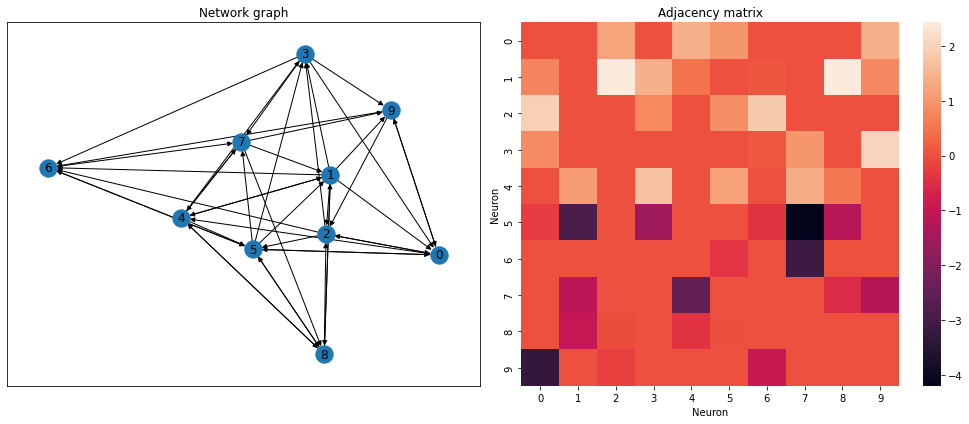

In [48]:
# visualisation of one of the networks generated
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

example_network = network_data[0]

G = to_networkx(example_network)
nx.draw_networkx(G, arrows=True, ax=ax[0])
ax[0].set_title("Network graph")

square_connectivity_matrix = to_dense_adj(example_network.edge_index, edge_attr=example_network.W0, max_num_nodes=example_network.num_nodes)[0]
sns.heatmap(square_connectivity_matrix, ax=ax[1])
ax[1].set_title("Adjacency matrix")
ax[1].set_xlabel("Neuron")
ax[1].set_ylabel("Neuron")

plt.tight_layout()
plt.show()

### TO DO:

- Give each neuron a random position in a square grid
- Create stimulus masks as function of neuron's distance to stimulation location
- Define a function for stimulation, parameterized by strength and duration

In [69]:
neuron_model.tune(example_network, firing_rate=100.0, tunable_parameters=["theta"], n_steps=1000, lr=1e-3, n_epochs=1000)

Tuning... fr=19.18784: 100%|████████████████| 1000/1000 [01:49<00:00,  9.11it/s]


In [10]:
neuron_model.tunable_parameters

{'theta': Parameter containing:
 tensor(4.6288),
 'beta': Parameter containing:
 tensor(0.3000),
 'alpha': Parameter containing:
 tensor(0.2000),
 'rel_ref_strength': Parameter containing:
 tensor(-30.)}

In [5]:
def set_position(network):
    N = network.num_nodes
    positions = np.zeros((N, 2))
    for i in range(N):
        positions[i] = np.random.uniform(size = 2)
        
    return positions   

def stimulus_mask(positions, stimulus_location, eps):
    N = positions.shape[0]
    x0, y0 = stimulus_location
    stimulus_mask = torch.zeros(N, dtype=torch.bool)
    
    for i in range(N):
        x, y = positions[i]
        distance = np.sqrt((x - x0)**2 + (y-y0)**2)
        
        if distance < eps:
            stimulus_mask[i] = True
    
    return stimulus_mask

In [6]:
eps=0.3
positions = set_position(example_network)
stimulus_location = positions[0]
stimulus_masks = stimulus_mask(positions, stimulus_location, eps=eps)

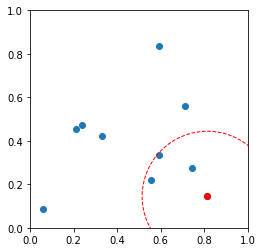

In [7]:
plt.scatter(positions[:,0], positions[:,1])
plt.scatter(stimulus_location[0], stimulus_location[1], color='r')
stimulus_domain = plt.Circle((stimulus_location[0], stimulus_location[1]), eps, color='r', fill=False, linestyle = '--')
plt.gca().add_patch(stimulus_domain)
plt.axis('square')
plt.xlim([0,1])
plt.ylim([0,1])
plt.show()

In [8]:
print(stimulus_masks)

tensor([ True,  True, False,  True, False, False, False, False, False,  True])


In [48]:
neuron_model.add_stimulus(lambda t: 2*(t % 1000 < 200)*stimulus_masks)

In [72]:
n_timesteps = 10**6
spikes = neuron_model.simulate(example_network, n_steps=n_timesteps, verbose=False)

In [62]:
import pandas as pd

In [73]:
print("Average firing rate:", spikes.float().mean().item()*1000)

Average firing rate: 26.068400591611862


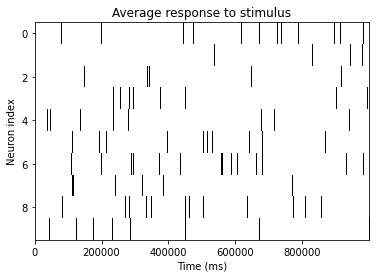

In [74]:
# Plot the results
stim_period = n_timesteps
plt.imshow(spikes, aspect="auto", cmap="binary", interpolation="none")
#plt.hlines(np.where(stimulus_masks == True)[0], xmin=0, xmax=stim_period-1, color="k", linestyle="--")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.title("Average response to stimulus")
#plt.tight_layout()
plt.show()

In [75]:
W0 = to_dense_adj(example_network.edge_index, edge_attr=example_network.W0, max_num_nodes=example_network.num_nodes)[0]
#X = X_batches[i*n_neurons:(i+1)*n_neurons]

#print("Average firing rate: ", (fr/neuron_model.dt).item()*1000, "Hz")
#print("Average ISI: ", isi.item(), "ms")

np.savez(f'data/{n_neurons}_neurons_{n_timesteps}_timesteps_20Hz',
        X = spikes,
        W0 = W0,
        model_params = neuron_model.tunable_parameters
        )

In [52]:
neuron_model.save('data/model.pt')

In [76]:
neuron_model.tunable_parameters

{'theta': Parameter containing:
 tensor(2.9943),
 'beta': Parameter containing:
 tensor(0.2000),
 'alpha': Parameter containing:
 tensor(0.5000),
 'rel_ref_strength': Parameter containing:
 tensor(-30.)}

### Learn structure with linear regression

In [ ]:
true_effect = torch.sigmoid(W0 - theta) - torch.sigmoid(-theta)